In [ ]:
!pip install torch torchvision pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!cp "/content/content.jpg" ./content.jpg
!cp "/content/style.jpg" ./style.jpg

cp: '/content/content.jpg' and './content.jpg' are the same file
cp: '/content/style.jpg' and './style.jpg' are the same file


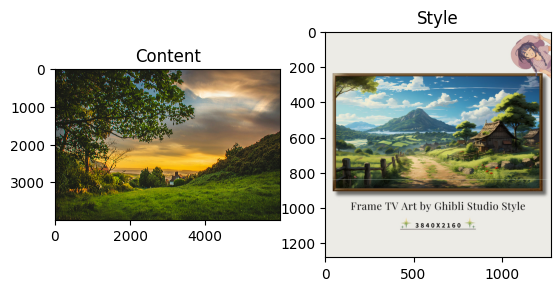

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

content_img = Image.open("content.jpg").convert("RGB")
style_img = Image.open("style.jpg").convert("RGB")

plt.subplot(1, 2, 1)
plt.imshow(content_img)
plt.title("Content")

plt.subplot(1, 2, 2)
plt.imshow(style_img)
plt.title("Style")

plt.show()

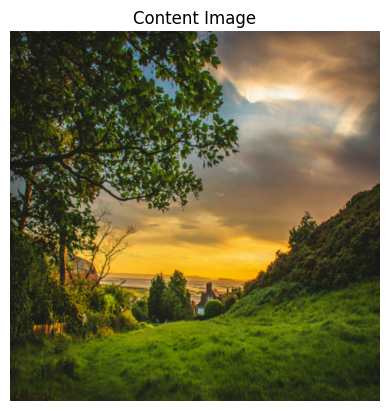

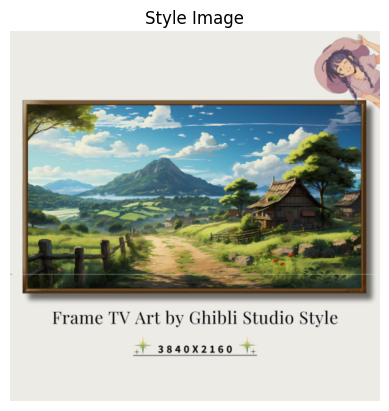

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy

# Use CPU
device = torch.device("cpu")

# Load and resize image
def load_image(img_path, max_size=512):
    image = Image.open(img_path).convert('RGB')
    size = min(max(image.size), max_size)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

# Display image
def imshow(tensor, title=None):
    image = tensor.clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title: plt.title(title)
    plt.axis('off')
    plt.show()

# Your images
content_path = "/content/content.jpg"
style_path   = "/content/style.jpg"

content_img = load_image(content_path)
style_img   = load_image(style_path)

assert content_img.size() == style_img.size(), "Images must be the same size"

# Show input images
imshow(content_img, "Content Image")
imshow(style_img, "Style Image")


In [ ]:
# VGG19 model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Normalization layer
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std  = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Content and style layers
content_layers = ['conv_4']
style_layers   = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Helper for normalization
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.view(-1,1,1)
        self.std  = std.view(-1,1,1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Content loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

# Style loss using Gram matrix
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a*b, c*d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 69.5MB/s]


In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # Increment for conv layers
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim model after last loss layer
    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    model = model[:i+1]

    return model, style_losses, content_losses


Optimizing... (10 minutes on CPU)
Step 50: Style Loss: 0.0002 | Content Loss: 16.1570
Step 100: Style Loss: 0.0001 | Content Loss: 16.9051
Step 150: Style Loss: 0.0001 | Content Loss: 17.9097
Step 200: Style Loss: 0.0001 | Content Loss: 18.4753


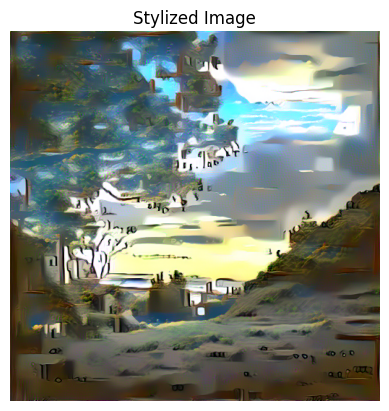

Saved output to /content/stylized_output.png


In [ ]:
# Input image (copy of content)
input_img = content_img.clone()

# Optimize pixels directly
optimizer = optim.LBFGS([input_img.requires_grad_()])

model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    style_img, content_img)

print("Optimizing... (10 minutes on CPU)")
num_steps = 200  # Lower this if you want faster (less artistic), 300 is okay for 10 mins

run = [0]
while run[0] <= num_steps:

    def closure():
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        loss = style_score * 1e6 + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]}: Style Loss: {style_score.item():.4f} | Content Loss: {content_score.item():.4f}")

        return loss

    optimizer.step(closure)

# Final clamping and display
input_img.data.clamp_(0, 1)
imshow(input_img, title="Stylized Image")

# Save
save_path = "/content/stylized_output.png"
transforms.ToPILImage()(input_img.squeeze()).save(save_path)
print(f"Saved output to {save_path}")
